# Obtaining an initial trajectory for fixed-length TPS

This notebook is part of the fixed length TPS example. It requires the file `ad_tps_equil.nc`, which is written in the notebook `AD_tps_1_trajectory.ipynb`.

In this notebook, you will learn:
* how to set up a `FixedLengthTPSNetwork`
* how to extend a transition path to satisfy the fixed length TPS ensemble
* how to save specific objects to a file

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

import openpathsampling as paths

## Loading from storage

First, we open the file we made in `AD_tps_1_trajectory.ipynb` and load various things we need from that.

In [2]:
old_storage = paths.Storage("ad_tps_equil.nc", "r")

In [3]:
engine = old_storage.engines['300K']
C_7eq = old_storage.volumes['C_7eq']
alpha_R = old_storage.volumes['alpha_R']
traj = old_storage.samplesets[-1][0].trajectory

# load CVs for plotting
phi = old_storage.cvs['phi']
psi = old_storage.cvs['psi']

## Building a trajectory to suit the ensemble

We're starting from a trajectory that makes the transition. However, we need that trajectory to be longer than it is.

There's an important subtlety here: we can't just extend the trajectory in one direction until is satisfies our length requirement, because it is very possible that the final frame would be in the no-man's-land that isn't either state, and then it wouldn't satisfy the ensemble. (Additionally, without a shifting move, having the transition at the far edge of the trajectory time could be problematic.)

So our approach here is to extend the trajectory in either direction by half the fixed length. That gives us a total trajectory length of the fixed length plus the length of the original trajectory. Within this trajectory, we try to find an subtrajectory that satisfies our ensemble. If we don't, then we add more frames to each side and try again.

In [4]:
network = paths.FixedLengthTPSNetwork(C_7eq, alpha_R,
                                      length=400).named('fixed_tps_network')

In [5]:
trajectories = []
i=0
while len(trajectories) == 0 and i < 5:
    max_len = 200 + i*50
    fwd_traj = engine.generate(traj[-1], [lambda traj, foo: len(traj) < max_len])
    bkwd_traj = engine.generate(traj[0], [lambda traj, foo: len(traj) < max_len], direction=-1)
    new_traj = bkwd_traj[:-1] + traj + fwd_traj[1:]
    trajectories = network.sampling_ensembles[0].split(new_traj)
    print(trajectories)

/scratch/dswenson/miniconda/envs/dev/lib/python3.7/site-packages/mdtraj/utils/validation.py:116: TypeCastPerformanceWarning: Casting unitcell_vectors dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


[Trajectory[400]]


In [6]:
# raises an error if we still haven't found a suitable trajectory
trajectory = trajectories[0]

## Plot the trajectory

This is exactly as done in `AD_tps_1_trajectory.ipynb`.

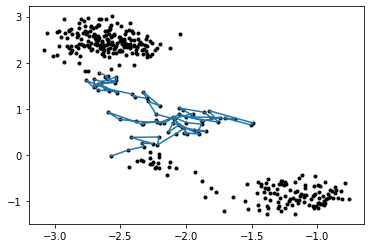

In [7]:
plt.plot(phi(trajectory), psi(trajectory), '.k')
plt.plot(phi(traj), psi(traj))

## Save stuff

When we do path sampling, the `PathSampling` object automatically handles saving for us. However, we can also save things explicitly. If you save an object that contains another object, the inner object will be saved. For example, saving the network will also save both of the stable states (which, in turn, save the CVs).

In [8]:
storage = paths.Storage("ad_fixed_tps_traj.nc", "w")

In [9]:
storage.save(trajectory)
storage.save(network)
storage.save(engine);  # not technically required, saved with trajectory

In [10]:
storage.close()
old_storage.close()